Using device: cuda
Epoch 1, Loss: 0.0367
Epoch 2, Loss: 0.0149
Epoch 3, Loss: 0.0121
Epoch 4, Loss: 0.0107
Epoch 5, Loss: 0.0099
Epoch 6, Loss: 0.0093
Epoch 7, Loss: 0.0090
Epoch 8, Loss: 0.0087
Epoch 9, Loss: 0.0085
Epoch 10, Loss: 0.0083
Epoch 11, Loss: 0.0082
Epoch 12, Loss: 0.0080
Epoch 13, Loss: 0.0080
Epoch 14, Loss: 0.0079
Epoch 15, Loss: 0.0078
Epoch 16, Loss: 0.0077
Epoch 17, Loss: 0.0076
Epoch 18, Loss: 0.0076
Epoch 19, Loss: 0.0075
Epoch 20, Loss: 0.0075


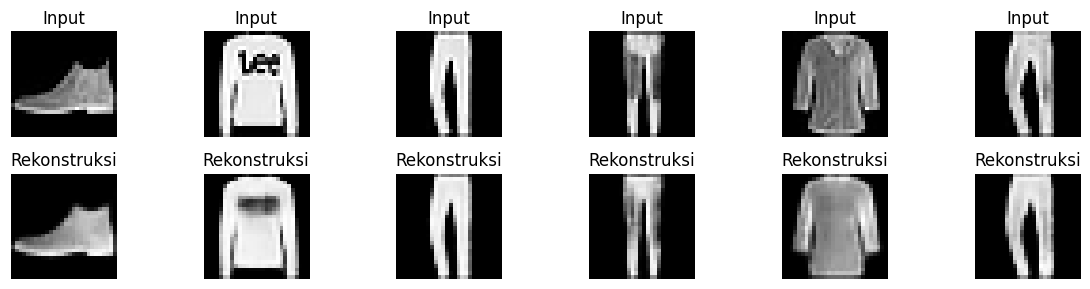

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transformasi
transform = transforms.ToTensor()

# ⛳️ PAKAI PATH YANG BISA DITULIS
train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Model Autoencoder (output = 28x28)
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B,16,14,14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B,32,7,7]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # [B,64,7,7]
            nn.ReLU()
        )
        self.fc1 = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),                # 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 1x28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc1(x)

    def decode(self, z):
        z = self.fc2(z)
        z = z.view(z.size(0), 64, 7, 7)
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

# Inisialisasi
model = ConvAutoencoder(latent_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Visualisasi Rekonstruksi
model.eval()
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
with torch.no_grad():
    outputs, _ = model(images)

# Tampilkan 6 gambar dan rekonstruksi
n = 6
plt.figure(figsize=(12, 3))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
    plt.title("Rekonstruksi")
    plt.axis('off')
plt.tight_layout()
plt.show()
